In [1]:
%matplotlib notebook
import h5py
import numpy as np
import matplotlib.pyplot as plt
from plotutility import estimatorscope

In [ ]:
np.all(np.isfinite(np.full(3,np.nan)))

In [ ]:
def estimatorscope(estimator,truth,sensors,listofest,samplerate,traces):
    # create figure and axes 
    fig, axes = plt.subplots(len(traces), figsize=(10, 5))
    lines=[]
    
    numcycles= len(sensors)
    numdata= numcycles//samplerate
    numtraces= len(traces)
    datas=[np.full(numdata,np.nan) for i in range(numtraces)]
    if numtraces==1:
        axes=[axes]
    for i in range(numtraces):
        line, = axes[i].plot(datas[i], 'ro')
        lines.append(line)
        axes[i].axis(xmin=0,xmax=numdata)
        axes[i].set_title(str(traces[i]))
    #create animation update function
    def init():
        return lines
    def update(frame_num):
        cyclenum= frame_num*samplerate
        for i in range(samplerate):
            estimator.input(sensors[cyclenum])
            cyclenum+= 1
        listofest.append(copy.deepcopy(estimator))
        for i in range(numtraces):
            datas[i][frame_num]=traces[i](estimator,sensors[cyclenum-1],truth[cyclenum-1])
            lines[i].set_ydata(datas[i])
            axes[i].relim()
            axes[i].autoscale_view(scalex=True, scaley=True)
        return lines
    line_ani = animation.FuncAnimation(fig, update, range(numdata), init_func= init,
                                   interval=1, blit=True,repeat=False)
    return line_ani

In [2]:
class Estimator1:
    def __init__(self,alpha):
        self.alpha= alpha
        self.r=np.full(3,np.nan)
    def input(self,sensors):
        s_r= sensors['r']
        if np.all(np.isfinite(s_r)):
            self.r[:]= s_r;

def norm_pos_error_m(estimator,sensors,truth):
    return np.linalg.norm(estimator.r-truth['r'])

In [7]:
f= h5py.File("test-files/Gracetest.hdf5","r")   
truth= f['truth'][()]
sensors= f['sensors'][()]
f.close()

<IPython.core.display.Javascript object>


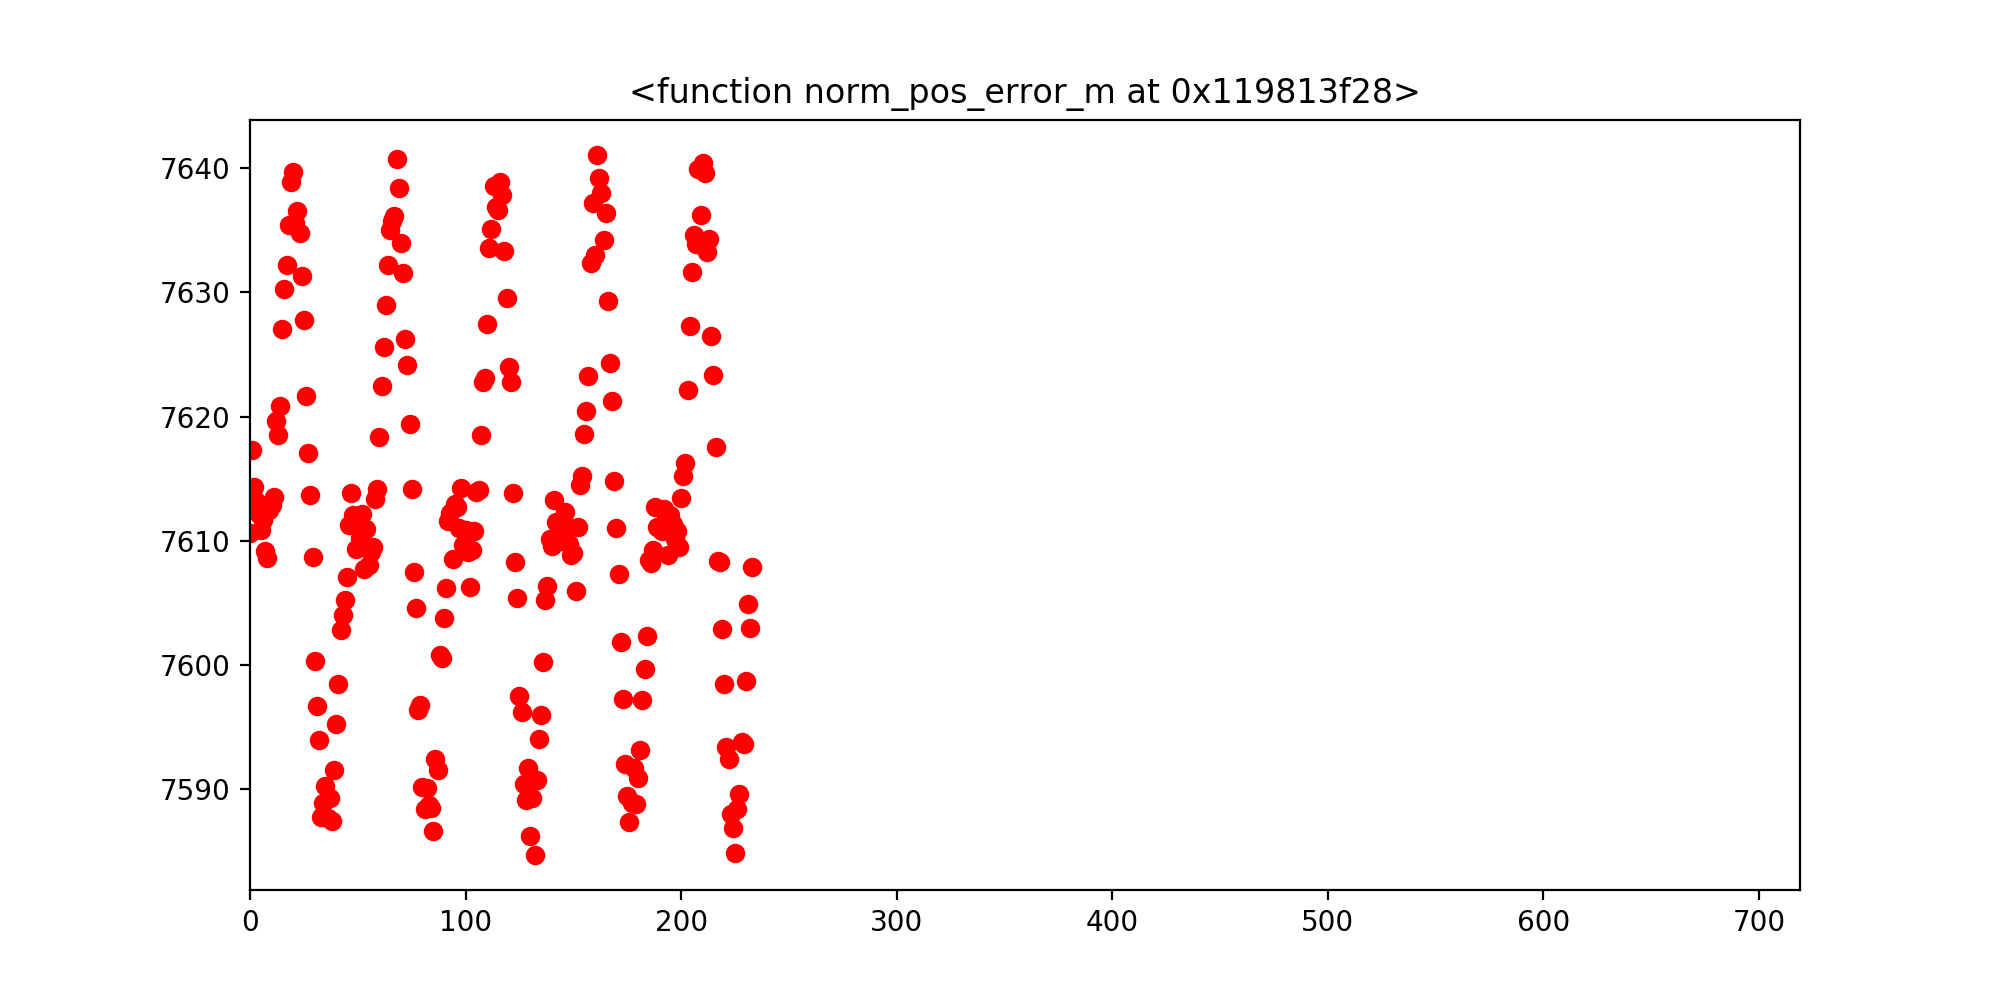

In [4]:
b=[]
samplerate=1000
a= estimatorscope(Estimator1(1.0),truth,sensors,b,samplerate,[norm_pos_error_m])
plt.show()

In [6]:
len(b)

235